<a href="https://colab.research.google.com/github/vvekraman/Missing-Class-Robust-Domain-Adaptation-by-Unilateral-Alignment/blob/main/Implementation_DAUA_CWRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from scipy.io import loadmat
from glob import glob
import numpy as np
from numpy import array
import random

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization, Conv1D
from tensorflow.keras.utils import to_categorical

In [ ]:
# data
!rm -rf "/content/data_12k_cwru"
!unzip "/content/drive/MyDrive/data/data_12k_cwru.zip"
!rm -rf "/content/checkpoints"
!mkdir -p checkpoints

In [10]:
# setting dev to GPU
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [11]:
# consideing only the drive end (DE) data
# load = one of [0,1,2,3]
# percentage = "full" or "20%"

# returns labels along with the path to data (.mat files)
def get_cwru_lists(load, percentage, dir="/content/data_12k_cwru/",):

  if percentage =="20%":
    lists = {0: dir + "Normal_" + str(load) + ".mat",
             1: dir + "IR007_" + str(load) + ".mat"}
  else:
    lists = {0: dir + "Normal_" + str(load) + ".mat",
             1: dir + "IR007_" + str(load) + ".mat",
             2: dir + "IR014_" + str(load) + ".mat",
             3: dir + "IR021_" + str(load) + ".mat",
             4: dir + "B007_" + str(load) + ".mat",
             5: dir + "B014_" + str(load) + ".mat",
             6: dir + "B021_" + str(load) + ".mat",
             7: dir + "OR007@6_" + str(load) + ".mat",
             8: dir + "OR014@6_" + str(load) + ".mat",
             9: dir + "OR021@6_" + str(load) + ".mat"}

  return {label: glob(lists[label]) for label in lists}

In [12]:
# returns data and labels
def cwru_data(load, percentage, truncate=120000, length=1024, sample=200, shuffle=False):
  # getting the dict with lables and path to data
  file_dirs = get_cwru_lists(load, percentage)

  out = []
  lbls = []

  for lbl in file_dirs:
    # loading the .mat - lbl can be [0,1,2,3,4,5,6,7,8,9] when percentage="all" 
    # or [0,1] when percentage="20%"
    data = loadmat(file_dirs[lbl][0])
    for i in data:
      # taking only the DE list of values
      if "DE" in i:
        data = data[i][:truncate] # truncating the length of data
        data = [data[j:j + length] for j in range(0, len(data) - length + 1 , (len(data) - length)//(sample - 1) )] # sampling
        # carrying out fft
        for k in range(0,len(data)):
          fft = abs(np.fft.fft(data[k])[:len(data[k])//2])
          out.append(fft)
          lbls.append([lbl])
      else:
        pass

  # in case of "20%", i.e., the out is target data
  # len(out)=400 and len of source data will be 2000
  # here the target data is stacked 5 times to make the len 2000
  # to match with the source data length
  if percentage=="20%":
    out = out*5
    lbls = lbls*5

  # shuffling the data by setting the same seed val
  if shuffle:
    random.seed(0)
    random.shuffle(out)
    random.seed(0)
    random.shuffle(lbls)
  
  # one hot encoding
  lbls = to_categorical(array(lbls))

  return np.array(out), np.array(lbls)

In [13]:
# preparing data for stage 1
# out of 2000, 1600 for training and 400 for testing
data, labels = cwru_data(load=0, percentage="full", shuffle=True)
x_train, x_test = data[:1600], data[1600:]
y_train, y_test = labels[:1600], labels[1600:]

In [14]:
# def input shape
input_shape = (512,1)

#model s1
def net_s1():
  seq = Sequential()
  seq.add(Conv1D(10, kernel_size=3, name='conv_1', input_shape= input_shape))
  seq.add(Dropout(0.5))
  seq.add(Conv1D(10, kernel_size=3, name='conv_2'))
  seq.add(Dropout(0.5))
  seq.add(Conv1D(10, kernel_size=3, name='conv_3'))
  seq.add(Dropout(0.5))

  seq.add(Flatten())

  seq.add(Dense(256, activation=tf.nn.sigmoid))

  seq.add(Dense(256, activation=tf.nn.relu))
  seq.add(Dropout(0.5))
  seq.add(Dense(10,activation=tf.nn.softmax))
  return seq

In [15]:
# creating and compiling the model
model_s1 = net_s1()
model_s1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
# fitting the model
model_s1.fit(x=x_train, y=y_train, epochs=50)

In [17]:
# model evaluation
model_s1.evaluate(x_test, y_test)

13/13 [==============================] - 0s 6ms/step - loss: 0.0258 - accuracy: 0.8350


[0.02581583335995674, 0.8349999785423279]

**STAGE 2**

In [18]:
# pre-trained model_s1 with classifier removed
model_s1_FExt = Model(model_s1.input, model_s1.layers[-4].output)
model_s1_FExt.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1_input (InputLayer)    [(None, 512, 1)]          0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 510, 10)           40        
_________________________________________________________________
dropout (Dropout)            (None, 510, 10)           0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 508, 10)           310       
_________________________________________________________________
dropout_1 (Dropout)          (None, 508, 10)           0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 506, 10)           310       
_________________________________________________________________
dropout_2 (Dropout)          (None, 506, 10)           0     

In [19]:
# defining a custom gradient
@tf.custom_gradient
def grad_reverse(x):
  y = tf.identity(x)
  def custom_grad(dy):
    return -dy
  return y, custom_grad

In [20]:
# GRL
class GradReverse(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return grad_reverse(x)

flip_grad = GradReverse()

In [21]:
# STAGE 2

def net_s2(input_shape):
  inp = Input(input_shape)
  x = Conv1D(10, kernel_size=3, name='conv_1', input_shape= input_shape)(inp)
  x = Dropout(0.5)(x)
  x = Conv1D(10, kernel_size=3, name='conv_2')(x)
  x = Dropout(0.5)(x)
  x = Conv1D(10, kernel_size=3, name='conv_3')(x)
  x = Dropout(0.5)(x)

  x = Flatten()(x)

  features_s2 = Dense(256, activation=tf.nn.sigmoid)(x)

  # classifier
  out = Dense(256, activation=tf.nn.relu)(features_s2)
  out = Dropout(0.5)(out)
  out_classf = Dense(10)(out)

  # discriminator
  flipg = flip_grad(features_s2)
  dom = Dense(1024, activation=tf.nn.relu)(flipg)
  dom = Dense(1024, activation=tf.nn.relu)(dom)
  out_disc = Dense(2)(dom)

  model_s2 = Model(inp, [out_classf, out_disc])

  return model_s2

In [22]:
# STAGE 2 model and optimizer
model_s2 = net_s2(input_shape)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

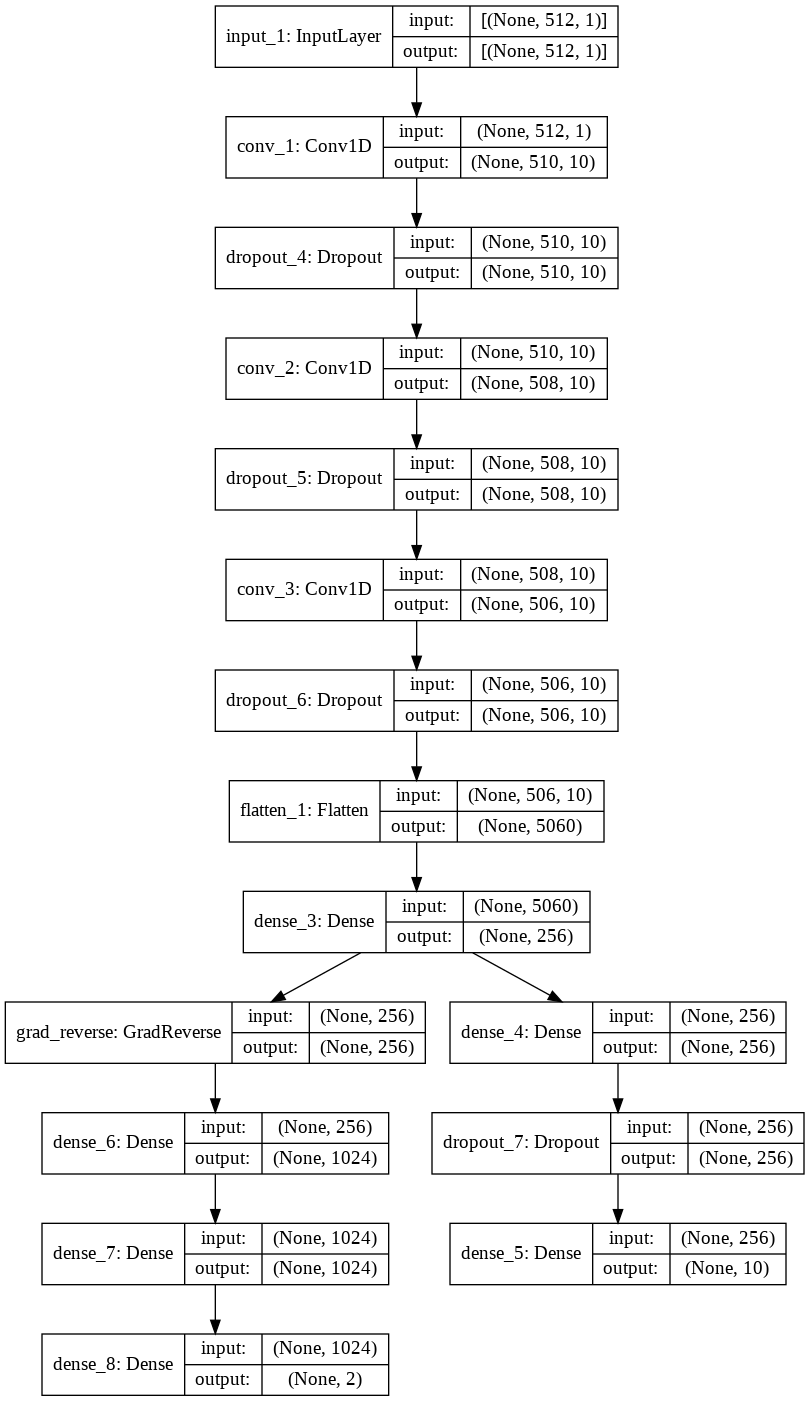

In [29]:
# plot model_s2
from keras.utils.vis_utils import plot_model
plot_model(model_s2, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [24]:
# Task 0 −→ 1 means working load 0 is the source domain with labeled training samples, and
# working load 1 is the target domain we want to improve model performance on.
src = 0
tgt = 1

# retrives the complete source data for training
src_data, src_labels = cwru_data(load=src, percentage="full", shuffle=True)

# retrives 20% of the target data for training
tgt_data, tgt_labels = cwru_data(load=tgt, percentage="20%", shuffle=True)

# retrives all of the target data for testing
tgt_data_full, tgt_labels_full = cwru_data(load=1, percentage="all")

# creating dataset
src_data_gen = tf.data.Dataset.from_tensor_slices((src_data, src_labels))
tgt_data_gen = tf.data.Dataset.from_tensor_slices((tgt_data, tgt_labels))
tgt_data_gen_full = tf.data.Dataset.from_tensor_slices((tgt_data_full, tgt_labels_full))

# batch size
batch_size = 64

# creating data generators (full and half) for training and testing
src_data_gen_f = src_data_gen.batch(batch_size=batch_size, drop_remainder=True)
tgt_data_gen_f = tgt_data_gen.batch(batch_size=batch_size, drop_remainder=True)

# for the feature extractor+discriminator combination, half of the data should be
# from source and the other half from target
src_data_gen_h = src_data_gen.batch(batch_size=batch_size//2, drop_remainder=True)
tgt_data_gen_h = tgt_data_gen.batch(batch_size=batch_size//2, drop_remainder=True)

# data generator for validation
tgt_data_gen_test = tgt_data_gen_full.batch(batch_size=1)

In [ ]:
# training Loop
val_loss = []
old_val_acc = 0

plot_val_loss = []
plot_tr_loss = []
plot_val_accu = []
plot_tr_accu = []

cat_tr_acc = tf.metrics.CategoricalAccuracy()
cat_val_acc = tf.metrics.CategoricalAccuracy()

epochs = 80

progbar = tf.keras.utils.Progbar(len(src_data)//batch_size)

for epoch in range(epochs):
  # training performance metrics init
  tr_accu =[]
  tr_loss = [] 

  print("\nepoch:", epoch+1)
  for step, (src_f, src_h, tgt_h) in enumerate(zip(src_data_gen_f, src_data_gen_h, tgt_data_gen_h)):
    with tf.GradientTape() as tape:
      # classification and loss
      out_classf,_ = model_s2(src_f[0], training=True)
      loss_clf = tf.nn.softmax_cross_entropy_with_logits(labels=src_f[1], logits=out_classf)

      # consistency loss from feature maps of inputs from model_s1 and model_s2
      model_s2_FExt = Model(model_s2.input, model_s2.layers[8].output)
      feat_s2 = model_s2_FExt(src_f[0], training=False)
      feat_s1 = model_s1_FExt(src_f[0], training=False)
      loss_cons = np.sum(np.abs((feat_s1-feat_s2)), axis=1)/len(feat_s1[0])

      # loss of discriminator
      pair = tf.concat([src_h[0],tgt_h[0]],0)
      dom_lbl = np.vstack(([[1.,0.]]*(batch_size//2), [[0.,1.]]*(batch_size//2)))
      _,out_disc = model_s2(pair, training=True)
      loss_d = tf.nn.softmax_cross_entropy_with_logits(labels=dom_lbl, logits=out_disc)

      l = 1 #lambda (regularisation term for the consistency loss)
      loss_value = loss_clf + loss_d + l*loss_cons  # total loss

    grads = tape.gradient(loss_value, model_s2.trainable_weights)
    optimizer.apply_gradients(zip(grads, model_s2.trainable_weights))

    # update training metric.
    tr_accu.append(cat_tr_acc(src_f[1], tf.nn.softmax(out_classf)))

    # update training loss
    tr_loss.append(np.average(loss_value))

    progbar.update(step+1)  #updates prog bar

  # validation
  val_lbls=[]
  val_output=[]
  val_loss=[]
  for i, dat in enumerate(tgt_data_gen_test):
    out,_ = model_s2(dat[0], training=False)
    val_loss.append(tf.nn.softmax_cross_entropy_with_logits(labels=dat[1], logits=out))
    val_lbls.append(dat[1])
    val_output.append(out)
  # validation accuracy
  val_accu = cat_val_acc(val_lbls, tf.nn.softmax(val_output))

  # saving the best checkpoint
  if val_accu.numpy() > old_val_acc:
    model_s2.save_weights("/content/checkpoints/checkpoint-" + str(epoch+1) + ".ckpt")
    old_val_acc = val_accu.numpy()
    print("Checkpoint saved!")

  # Display metrics at the end of each epoch.
  print("\nStats:", 
        "\nTraining accuracy:", np.average(tr_accu), 
        "\nTraining loss:", np.average(tr_loss),
        "\nValidation accuracy:",val_accu.numpy() ,
        "\nValidation loss:", np.average(val_loss))

  # saving val & tr loss for plotting
  plot_val_loss.append(np.average(val_loss))
  plot_tr_loss.append(np.average(tr_loss))
  plot_val_accu.append(val_accu.numpy())
  plot_tr_accu.append(np.average(tr_accu))

In [ ]:
#loading saved models
#model_s2 = net_s2(input_shape)
#model_s2.load_weights("/content/checkpoints/checkpoint-40.ckpt")

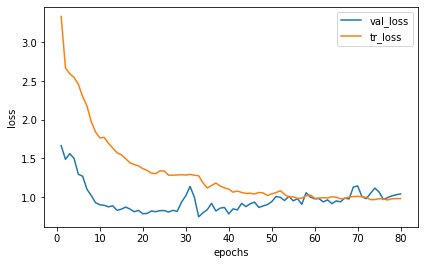

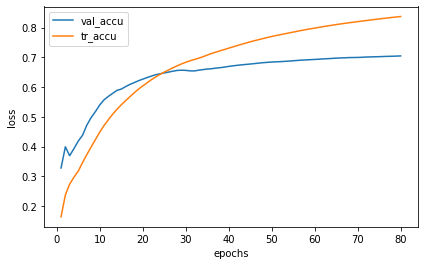

In [28]:
# plot
plt.figure(figsize=(6, 7))
plt.subplot(2,1,1)
plt.plot(np.arange(1, len(plot_val_loss)+1),plot_val_loss, label="val_loss")
plt.plot(np.arange(1, len(plot_tr_loss)+1),plot_tr_loss, label="tr_loss")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 7))
plt.subplot(2,1,2)
plt.plot(np.arange(1, len(plot_val_accu)+1),plot_val_accu, label="val_accu")
plt.plot(np.arange(1, len(plot_tr_accu)+1),plot_tr_accu, label="tr_accu")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.tight_layout()
plt.show()